In [1]:
import tensorflow as tf
tf.set_random_seed(123)
import numpy as np
np.random.seed(123)

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")

train_data_provider = mnist.train
validation_data_provider = mnist.validation
test_data_provider = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
import os
class BaseNetwork:

    @property
    def sess(self):
        if not hasattr(self, '_sess'):
            config = tf.ConfigProto()
            # to save GPU resources
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config, graph=self.graph)
        return self._sess

    def init_variables(self, var_list):

        self.sess.run(tf.variables_initializer(var_list))

    def number_of_parameters(self, var_list):
        return sum(np.prod(v.get_shape().as_list()) for v in var_list)

    def save_model(self, path=None, sess=None, global_step=None, verbose=True):
        save_dir = path or self.model_path
        os.makedirs(save_dir, exist_ok=True)
        self.saver.save(sess or self.sess,
                        os.path.join(save_dir, 'model.ckpt'),
                        global_step=global_step)
        return self

    def load_model(self, path=None, sess=None, verbose=True):
        path = path or self.model_path
        ckpt = tf.train.get_checkpoint_state(path)
        if ckpt is None:
            raise FileNotFoundError('Can`t load a model. '\
            'Checkpoint does not exist.')    
        restore_path = ckpt.model_checkpoint_path
        self.saver.restore(sess or self.sess, restore_path)

        return self

In [5]:
def get_second_dimension(tensor):
    return tensor.get_shape().as_list()[1]

In [10]:
from typing import Union
from tqdm import tqdm

class FullyConnectedClassifier(BaseNetwork):

    def __init__(self,
                 input_size: int,
                 n_classes: int,
                 layer_sizes: list,
                 model_path: str,
                 activation_fn=tf.nn.relu,
                 dropout=0.25,
                 momentum=0.9,
                 weight_decay=0.0005,
                 scope='FullyConnectedClassifier',
                 verbose=True,
                 pruning_threshold=None):

        """Create an instance of FullyConnectedClassifier"""

        self.input_size = input_size
        self.n_classes = n_classes
        self.layer_sizes = layer_sizes + [n_classes]
        self.model_path = model_path
        self.activation_fn = activation_fn
        self.dropout = dropout
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.scope = scope
        self.verbose = verbose
        self.pruning_threshold = pruning_threshold

        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.variable_scope(self.scope):

                self._create_placeholders()

                self.logits = self._build_network(inputs=self.inputs,
                                                  layer_sizes=self.layer_sizes,
                                                  activation_fn=self.activation_fn,
                                                  keep_prob=self.keep_prob)

                self.loss = self._create_loss(logits=self.logits,
                                              labels=self.labels,
                                              weight_decay=self.weight_decay)

                self.train_op = self._create_optimizer(self.loss,
                                                       learning_rate=self.learning_rate,
                                                       momentum=momentum,
                                                       threshold=pruning_threshold)

                self._create_metrics(logits=self.logits,
                                     labels=self.labels,
                                     loss=self.loss)

                self.saver = self._create_saver(tf.global_variables())
                self.init_variables(tf.global_variables())

                if self.verbose:
                    print('\nSuccessfully created graph for {model}.'.format(
                                                                model=self.scope))
                    print('Number of parameters (four bytes == 1 parameter): {}.\n'.format(
                        int(self.number_of_parameters(tf.trainable_variables()))))


    def _create_placeholders(self):

        # create input nodes of a graph
    
        self.inputs = tf.placeholder(dtype=tf.float32,
                                     shape=(None, self.input_size),
                                     name='inputs')
    
        self.labels = tf.placeholder(dtype=tf.int64,
                                     shape=None,
                                     name='labels')
    
        self.keep_prob = tf.placeholder(dtype=tf.float32,
                                        shape=(),
                                        name='keep_prob')
    
        self.learning_rate = tf.placeholder(dtype=tf.float32,
                                            shape=(),
                                            name='learning_rate')
    
    def _build_network(self,
                       inputs: tf.Tensor,
                       layer_sizes: list,
                       activation_fn: callable,
                       keep_prob: Union[tf.Tensor, float]) -> tf.Tensor:

        with tf.variable_scope('network'):
    
            net = inputs
    
            self.weight_matrices = []
            self.biases = []

            weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
            bias_initializer = tf.constant_initializer(0.1)

            # dynamically create a network

            for i, layer_size in enumerate(layer_sizes):
    
                with tf.variable_scope('layer_{layer}'.format(layer=i+1)):

                    name = 'weights'
                    shape = (get_second_dimension(net), layer_size)
                    weights = tf.get_variable(name=name,
                                              shape=shape,
                                              initializer=weights_initializer)

                    self.weight_matrices.append(weights)
                    # L2 loss
                    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES,
                                         tf.reduce_sum(weights ** 2))
        
                    name = 'bias'
                    shape = [layer_size]
                    bias = tf.get_variable(name=name,
                                           shape=shape,
                                           initializer=bias_initializer)
                    self.biases.append(bias)
    
                    net = tf.matmul(net, weights) + bias
    
                    # no activation and dropout on the last layer
                    if i < len(layer_sizes) - 1:
                        net = activation_fn(net)
                        net = tf.nn.dropout(net, keep_prob=keep_prob)
    
            return net
    
    def _create_loss(self,
                     logits: tf.Tensor,
                     labels: tf.Tensor,
                     weight_decay: float) -> tf.Tensor:
    
        with tf.variable_scope('loss'):
            classification_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                                            logits=logits, labels=labels,
                                            name='classification_loss')
    
            classification_loss = tf.reduce_mean(classification_loss,
                                                 name='classification_loss_averaged')

            l2_loss = weight_decay * tf.add_n(tf.losses.get_regularization_losses())
    
            return l2_loss + classification_loss

    def _create_optimizer(self,
                          loss: tf.Tensor,
                          learning_rate: Union[tf.Tensor, float],
                          momentum: Union[tf.Tensor, float],
                          threshold: float) -> tf.Operation:

        if threshold is not None:
            return self._create_optimizer_sparse(loss=loss,
                                                 threshold=threshold,
                                                 learning_rate=learning_rate,
                                                 momentum=momentum)
        with tf.variable_scope('optimizer'):

            optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                                   momentum=momentum,
                                                   name='optimizer')
            self.global_step = tf.Variable(0)
            train_op = optimizer.minimize(loss,
                                          global_step=self.global_step,
                                          name='train_op')

            return train_op

    def _apply_prune_on_grads(self,
                              grads_and_vars: list,
                              threshold: float):

        # we need to make gradients correspondent
        # to the pruned weights to be zero

        grads_and_vars_sparse = []

        for grad, var in grads_and_vars:
            if 'weights' in var.name:
                small_weights = tf.greater(threshold, tf.abs(var))
                mask = tf.cast(tf.logical_not(small_weights), tf.float32)
                grad = grad * mask

            grads_and_vars_sparse.append((grad, var))
               
        return grads_and_vars_sparse

    def _create_optimizer_sparse(self,
                                 loss: tf.Tensor,
                                 threshold: float,
                                 learning_rate: Union[tf.Tensor, float],
                                 momentum: Union[tf.Tensor, float]) -> tf.Operation:

        with tf.variable_scope('optimizer'):

            optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                                   momentum=momentum,
                                                   name='optimizer')
            self.global_step = tf.Variable(0)
            grads_and_vars = optimizer.compute_gradients(loss)
            grads_and_vars_sparse = self._apply_prune_on_grads(grads_and_vars,
                                                               threshold)
            train_op = optimizer.apply_gradients(grads_and_vars_sparse,
                                                 global_step=self.global_step,
                                                 name='train_op')

            return train_op

    def _create_metrics(self,
                        logits: tf.Tensor,
                        labels: tf.Tensor,
                        loss: tf.Tensor):

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), labels)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def _create_saver(self, var_list):

        saver = tf.train.Saver(var_list=var_list)
        return saver

    def fit(self,
            n_epochs: int,
            batch_size: int,
            learning_rate_schedule: callable,
            train_data_provider,
            validation_data_provider,
            test_data_provider):

        n_iterations = train_data_provider.num_examples // batch_size

        for epoch in range(n_epochs):
            print('Starting epoch {epoch}.\n'.format(epoch=epoch+1))
            for iteration in tqdm(range(n_iterations), ncols=75):

                images, labels = train_data_provider.next_batch(batch_size)

                feed_dict = {self.inputs: images,
                             self.labels: labels,
                             self.learning_rate: learning_rate_schedule(epoch+1),
                             self.keep_prob: 1 - self.dropout} 

                self.sess.run(self.train_op, feed_dict=feed_dict)
    
            # evaluate metrics after every epoch
            train_accuracy, train_loss = self.evaluate(train_data_provider,
                                                       batch_size=batch_size)
            validation_accuracy, validation_loss = self.evaluate(validation_data_provider,
                                                                 batch_size=batch_size)

            print('\nEpoch {epoch} completed.'.format(epoch=epoch+1))
            print('Accuracy on train: {accuracy}, loss on train: {loss}'.format(
                                    accuracy=train_accuracy, loss=train_loss))
            print('Accuracy on validation: {accuracy}, loss on validation: {loss}'.format(
                                    accuracy=validation_accuracy, loss=validation_loss))

        test_accuracy, test_loss = self.evaluate(test_data_provider,
                                                 batch_size=batch_size)

        print('\nOptimization finished.'.format(epoch=epoch+1))
        print('Accuracy on test: {accuracy}, loss on test: {loss}'.format(
                                accuracy=test_accuracy, loss=test_loss))

        self.save_model(global_step=self.global_step)

    def evaluate(self, data_provider, batch_size: int):

        fetches = [self.accuracy, self.loss]

        n_iterations = data_provider.num_examples // batch_size

        average_accuracy = 0
        average_loss = 0

        for iteration in range(n_iterations):

            images, labels = data_provider.next_batch(batch_size)

            feed_dict = {self.inputs: images,
                         self.labels: labels,
                         self.keep_prob: 1.0} 

            accuracy, loss = self.sess.run(fetches, feed_dict=feed_dict)
            
            average_accuracy += accuracy / n_iterations
            average_loss += loss / n_iterations

        return average_accuracy, average_loss

In [25]:
class ConfigNetworkDense:

    input_size = 28 * 28
    n_classes = 10
    layer_sizes = [1000, 1000, 500, 200]
    dropout = 0.5
    weight_decay = 0.0005
    activation_fn = tf.nn.relu
    model_path = 'saved_models/network_dense'

    n_epochs = 25
    batch_size = 100

    @staticmethod
    def learning_rate_schedule(epoch):

        if epoch < 10:
            return 1e-2
        elif epoch < 20:
            return 1e-3
        else:
            return 1e-4

class ConfigNetworkDensePruned:

    input_size = 28 * 28
    n_classes = 10
    layer_sizes = [1000, 1000, 500, 200]
    dropout = 0
    weight_decay = 0.0001
    activation_fn = tf.nn.relu
    model_path = 'saved_models/network_dense_pruned'
    pruning_threshold = 0.03

    n_epochs = 20
    batch_size = 100

    @staticmethod
    def learning_rate_schedule(epoch):

        if epoch < 10:
            return 1e-3
        else:
            return 1e-4

class ConfigNetworkSparse:

    input_size = 28 * 28
    n_classes = 10
    activation_fn = tf.nn.relu
    model_path = 'saved_models/network_sparse'
    batch_size = 100

In [26]:
classifier = FullyConnectedClassifier(input_size=ConfigNetworkDense.input_size,
                                                    n_classes=ConfigNetworkDense.n_classes,
                                                    layer_sizes=ConfigNetworkDense.layer_sizes,
                                                    model_path=ConfigNetworkDense.model_path,
                                                    dropout=ConfigNetworkDense.dropout,
                                                    weight_decay=ConfigNetworkDense.weight_decay,
                                                    activation_fn=ConfigNetworkDense.activation_fn)

# than train it
classifier.fit(n_epochs=ConfigNetworkDense.n_epochs,
               batch_size=ConfigNetworkDense.batch_size,
               learning_rate_schedule=ConfigNetworkDense.learning_rate_schedule,
               train_data_provider=train_data_provider,
               validation_data_provider=validation_data_provider,
test_data_provider=test_data_provider)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 115.39it/s]



Epoch 1 completed.
Accuracy on train: 0.11234545462172162, loss on train: 2.382831636342133
Accuracy on validation: 0.11259999938309194, loss on validation: 2.3828945112228386
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 141.99it/s]



Epoch 2 completed.
Accuracy on train: 0.5411090873046359, loss on train: 1.3049483676390212
Accuracy on validation: 0.5449999976158143, loss on validation: 1.2948278307914733
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 142.10it/s]



Epoch 3 completed.
Accuracy on train: 0.8997090928121062, loss on train: 0.4950586892799904
Accuracy on validation: 0.9056000018119811, loss on validation: 0.5015721809864043
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 140.94it/s]



Epoch 4 completed.
Accuracy on train: 0.9371090929074725, loss on train: 0.3631555180928924
Accuracy on validation: 0.9390000009536743, loss on validation: 0.37457269638776786
Starting epoch 5.



100%|████████████████████████████████████| 550/550 [00:06<00:00, 85.82it/s]



Epoch 5 completed.
Accuracy on train: 0.9522545476393275, loss on train: 0.30924045660278987
Accuracy on validation: 0.9510000002384187, loss on validation: 0.3304586723446846
Starting epoch 6.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 115.18it/s]



Epoch 6 completed.
Accuracy on train: 0.9622909127582192, loss on train: 0.27503564563664523
Accuracy on validation: 0.9594000041484831, loss on validation: 0.296380904018879
Starting epoch 7.



100%|████████████████████████████████████| 550/550 [00:05<00:00, 93.45it/s]



Epoch 7 completed.
Accuracy on train: 0.9681818243590248, loss on train: 0.25412577588449825
Accuracy on validation: 0.9670000016689296, loss on validation: 0.2796968045830728
Starting epoch 8.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.14it/s]



Epoch 8 completed.
Accuracy on train: 0.9724363721500714, loss on train: 0.2402526131272314
Accuracy on validation: 0.9674000108242031, loss on validation: 0.2683866894245148
Starting epoch 9.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.18it/s]



Epoch 9 completed.
Accuracy on train: 0.9760545543107084, loss on train: 0.22791125457395223
Accuracy on validation: 0.9720000040531158, loss on validation: 0.25806891739368437
Starting epoch 10.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 149.57it/s]



Epoch 10 completed.
Accuracy on train: 0.9806727375767409, loss on train: 0.21123867452144593
Accuracy on validation: 0.9744000101089478, loss on validation: 0.2455361151695252
Starting epoch 11.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 149.57it/s]



Epoch 11 completed.
Accuracy on train: 0.9820909193429053, loss on train: 0.20616390052166844
Accuracy on validation: 0.9740000092983244, loss on validation: 0.2429532384872437
Starting epoch 12.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.55it/s]



Epoch 12 completed.
Accuracy on train: 0.9825272840803296, loss on train: 0.20310400743376117
Accuracy on validation: 0.9750000095367434, loss on validation: 0.24039147138595582
Starting epoch 13.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.63it/s]



Epoch 13 completed.
Accuracy on train: 0.9835091017593003, loss on train: 0.19998135284944016
Accuracy on validation: 0.9762000143527984, loss on validation: 0.23922708511352547
Starting epoch 14.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.59it/s]



Epoch 14 completed.
Accuracy on train: 0.9838727388598671, loss on train: 0.19749079235575412
Accuracy on validation: 0.9756000077724455, loss on validation: 0.23795019060373304
Starting epoch 15.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.72it/s]



Epoch 15 completed.
Accuracy on train: 0.9846363747119878, loss on train: 0.19465119871226239
Accuracy on validation: 0.9756000077724456, loss on validation: 0.23528849869966503
Starting epoch 16.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 155.85it/s]



Epoch 16 completed.
Accuracy on train: 0.9850181925296747, loss on train: 0.19244352825663288
Accuracy on validation: 0.976600009202957, loss on validation: 0.2350234872102737
Starting epoch 17.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.47it/s]



Epoch 17 completed.
Accuracy on train: 0.9854545564001225, loss on train: 0.19050382527438073
Accuracy on validation: 0.9756000089645386, loss on validation: 0.23495179593563084
Starting epoch 18.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.88it/s]



Epoch 18 completed.
Accuracy on train: 0.9856727375767418, loss on train: 0.1883967905965719
Accuracy on validation: 0.9770000088214872, loss on validation: 0.23297013044357298
Starting epoch 19.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 149.65it/s]



Epoch 19 completed.
Accuracy on train: 0.9862000098011672, loss on train: 0.1861497967080636
Accuracy on validation: 0.9756000125408173, loss on validation: 0.23137821525335317
Starting epoch 20.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 146.98it/s]



Epoch 20 completed.
Accuracy on train: 0.9864181920615078, loss on train: 0.18521406165578144
Accuracy on validation: 0.9764000058174133, loss on validation: 0.23097135931253432
Starting epoch 21.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 149.33it/s]



Epoch 21 completed.
Accuracy on train: 0.9866363735632436, loss on train: 0.1847660984505307
Accuracy on validation: 0.97660001039505, loss on validation: 0.23093514233827586
Starting epoch 22.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 149.57it/s]



Epoch 22 completed.
Accuracy on train: 0.9868000094457087, loss on train: 0.18445912160656683
Accuracy on validation: 0.9768000090122221, loss on validation: 0.2306991070508957
Starting epoch 23.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.80it/s]



Epoch 23 completed.
Accuracy on train: 0.9869272833520688, loss on train: 0.18415818062695585
Accuracy on validation: 0.9770000088214874, loss on validation: 0.2303501603007317
Starting epoch 24.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.26it/s]



Epoch 24 completed.
Accuracy on train: 0.9868727369741935, loss on train: 0.1837971640987829
Accuracy on validation: 0.9764000070095059, loss on validation: 0.23024477988481518
Starting epoch 25.



100%|███████████████████████████████████| 550/550 [00:03<00:00, 150.59it/s]



Epoch 25 completed.
Accuracy on train: 0.9870181920311633, loss on train: 0.18357313153418614
Accuracy on validation: 0.9766000103950501, loss on validation: 0.23004573702812195

Optimization finished.
Accuracy on test: 0.974400011301041, loss on test: 0.23406469613313682


In [13]:
from matplotlib import pyplot as plt

def plot_histogram(weights_list: list,
                   image_name: str,
                   include_zeros=True):

    """A function to plot weights distribution"""

    weights = []
    for w in weights_list:
        weights.extend(list(w.ravel()))

    if not include_zeros:
        weights = [w for w in weights if w != 0]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    ax.hist(weights,
            bins=100,
            facecolor='green',
            edgecolor='black',
            alpha=0.7,
            range=(-0.15, 0.15))

    ax.set_title('Weights distribution')
    ax.set_xlabel('Weights values')
    ax.set_ylabel('Number of weights')

    fig.savefig(image_name + '.png')

In [14]:
import collections

# Weight Pruning, setting values of the weight of neurons equal to zero
def prune_weights(weights, pruning_threshold):
    small_weights = np.abs(weights) < pruning_threshold
    weights[small_weights] = 0
    values = weights[weights != 0]
    indices = np.transpose(np.nonzero(weights))
    return values, indices

def get_sparse_values_indices(weights):
    values = weights[weights != 0]
    indices = np.transpose(np.nonzero(weights))
    return values, indices

def mask_for_big_values(weights, pruning_threshold):
    small_weights = np.abs(weights) < pruning_threshold
    return np.logical_not(small_weights)

def calculate_number_of_sparse_parameters(sparse_layers):

    total_count = 0

    for layer in sparse_layers:

        total_count += layer.values.nbytes // 4
        total_count += layer.indices.nbytes // 4
        total_count += layer.dense_shape.nbytes // 4
        total_count += layer.bias.nbytes // 4

    return total_count

class SparseLayer(collections.namedtuple('SparseLayer',
                                         ['values',
                                          'indices',
                                          'dense_shape',
                                          'bias'])):

    """An auxilary class to represent sparse layer"""
    pass

In [15]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000027BAF30AB00>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000027BC80F6F98>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x0000027BC80F6390>)

In [16]:
train_data_provider

# Weight Pruning


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.974600011110306, loss on test: 0.12615751568227998
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:05<00:00, 108.54it/s]



Epoch 1 completed.
Accuracy on train: 0.9869818279959917, loss on train: 0.07497086186300625
Accuracy on validation: 0.9766000151634219, loss on validation: 0.12179115921258929
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 120.72it/s]



Epoch 2 completed.
Accuracy on train: 0.9871454643119438, loss on train: 0.0753677201067859
Accuracy on validation: 0.9770000112056734, loss on validation: 0.12182028353214262
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 122.09it/s]



Epoch 3 completed.
Accuracy on train: 0.9872181921655452, loss on train: 0.07414520113982942
Accuracy on validation: 0.9768000102043151, loss on validation: 0.12158899240195753
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 114.82it/s]



Epoch 4 completed.
Accuracy on train: 0.987818190943108, loss on train: 0.07295463593846015
Accuracy on validation: 0.9772000074386594, loss on validation: 0.12156511090695854
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 117.36it/s]



Epoch 5 completed.
Accuracy on train: 0.9875818268819266, loss on train: 0.07418291633779345
Accuracy on validation: 0.9764000093936919, loss on validation: 0.12155591800808907

Optimization finished.
Accuracy on test: 0.9746000111103058, loss on test: 0.12471961952745916


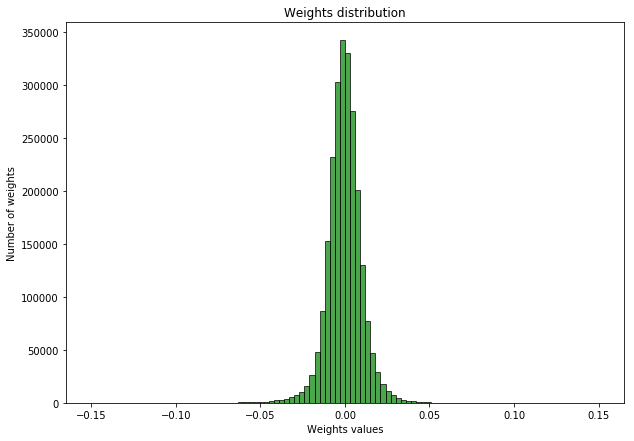

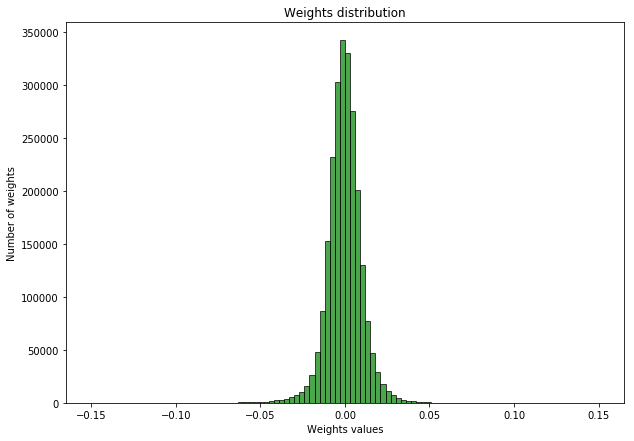

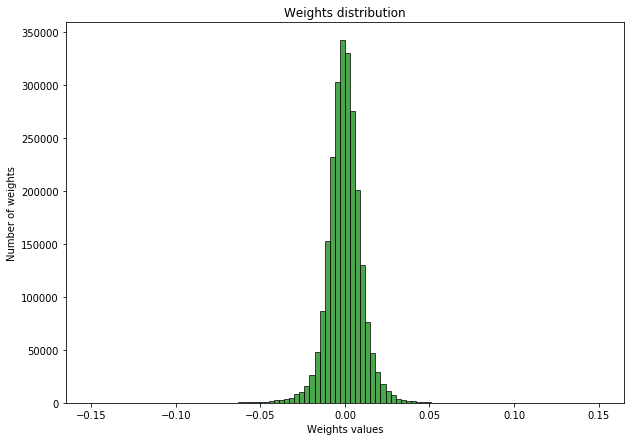

In [75]:
def weightPruning(pruning_percent):
    classifier = FullyConnectedClassifier(
                                input_size=ConfigNetworkDensePruned.input_size,
                                n_classes=ConfigNetworkDensePruned.n_classes,
                                layer_sizes=ConfigNetworkDensePruned.layer_sizes,
                                model_path=ConfigNetworkDensePruned.model_path,
                                dropout=ConfigNetworkDensePruned.dropout,
                                weight_decay=ConfigNetworkDensePruned.weight_decay,
                                activation_fn=ConfigNetworkDensePruned.activation_fn,
                                pruning_threshold=ConfigNetworkDensePruned.pruning_threshold)

    # collect tf variables and correspoding optimizer variables
    with classifier.graph.as_default():
        weight_matrices_tf = classifier.weight_matrices
        optimizer_matrices_tf = [v 
                                  for v in tf.global_variables()
                                  for w in weight_matrices_tf
                                  if w.name[:-2] in v.name
                                  and 'optimizer' in v.name]

    # load previously trained model
    # and get values of weights and optimizer variables
    weights, optimizer_weights = (classifier
                                 .load_model(ConfigNetworkDense.model_path)
                                 .sess.run([weight_matrices_tf,
                                            optimizer_matrices_tf]))

    # plot weights distribution before pruning
    weights = classifier.sess.run(weight_matrices_tf)
    plot_histogram(weights,'weights_distribution_before_pruning',include_zeros=False)

    # for each pair (weight matrix + optimizer matrix)
    # get a binary mask to get rid of small values. 
    # Than, based on this mask change the values of 
    # the weight matrix and the optimizer matrix  

    for (weight_matrix,
         optimizer_matrix,
         tf_weight_matrix,
         tf_optimizer_matrix) in zip(
         weights,
         optimizer_weights,
         weight_matrices_tf,
         optimizer_matrices_tf):

        mask =  mask_for_big_values(weight_matrix,pruning_percent)
        with classifier.graph.as_default():
            # update weights
            classifier.sess.run(tf_weight_matrix.assign(weight_matrix * mask))
            # and corresponding optimizer matrix
            classifier.sess.run(tf_optimizer_matrix.assign(optimizer_matrix * mask))

    # now, lets look on weights distribution (zero values are excluded)
    weights = classifier.sess.run(weight_matrices_tf)
    plot_histogram(weights,'weights_distribution_after_pruning',include_zeros=False)

    accuracy, loss = classifier.evaluate(data_provider=test_data_provider,
                                         batch_size=ConfigNetworkDensePruned.batch_size)
    print('Accuracy on test before fine-tuning: {accuracy}, loss on test: {loss}'.format(
                                                        accuracy=accuracy, loss=loss))

    # fine-tune classifier 
    classifier.fit(n_epochs=5,
                   batch_size=ConfigNetworkDensePruned.batch_size,
                   learning_rate_schedule=ConfigNetworkDensePruned.learning_rate_schedule,
                   train_data_provider=train_data_provider,
                   validation_data_provider=validation_data_provider,
                   test_data_provider=test_data_provider)

    # plot weights distribution again to see the difference
    weights = classifier.sess.run(weight_matrices_tf)
    plot_histogram(weights,'weights_distribution_after_fine_tuning',include_zeros=False)
weightPruning(0)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10380000006407504, loss on test: 2.3186462426185614
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:05<00:00, 103.84it/s]



Epoch 1 completed.
Accuracy on train: 0.09941818177700053, loss on train: 2.307634549140929
Accuracy on validation: 0.09760000005364415, loss on validation: 2.3065967178344726
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 121.26it/s]



Epoch 2 completed.
Accuracy on train: 0.0985090909695085, loss on train: 2.303667237975383
Accuracy on validation: 0.09760000061243776, loss on validation: 2.302557911872864
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 121.79it/s]



Epoch 3 completed.
Accuracy on train: 0.10056363623927962, loss on train: 2.301860252727163
Accuracy on validation: 0.09760000005364416, loss on validation: 2.3013998842239376
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 118.06it/s]



Epoch 4 completed.
Accuracy on train: 0.1130909090658483, loss on train: 2.301687401424756
Accuracy on validation: 0.11260000020265579, loss on validation: 2.3010151815414432
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 121.34it/s]



Epoch 5 completed.
Accuracy on train: 0.11363636342977948, loss on train: 2.301068778905001
Accuracy on validation: 0.11259999923408033, loss on validation: 2.3008741426467902

Optimization finished.
Accuracy on test: 0.11280000001192086, loss on test: 2.3011200785636903


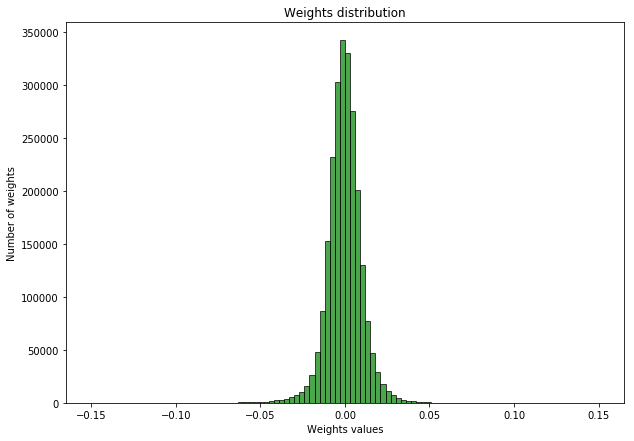

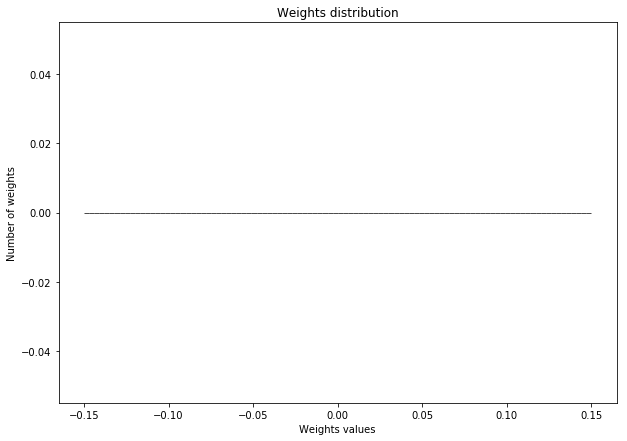

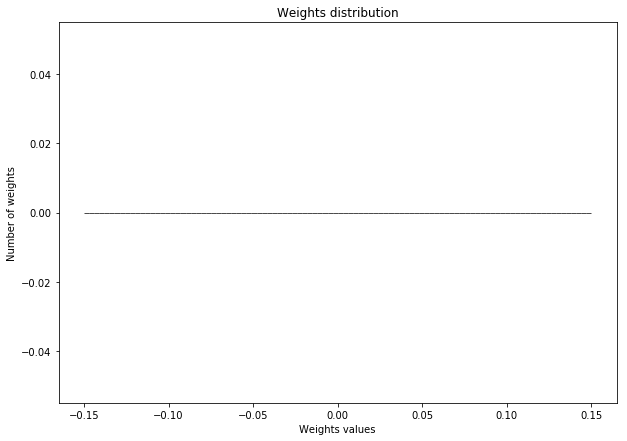

In [76]:
weightPruning(25)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10319999970495705, loss on test: 2.319068796634674
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:05<00:00, 107.37it/s]



Epoch 1 completed.
Accuracy on train: 0.09910909073596667, loss on train: 2.307703727808866
Accuracy on validation: 0.09759999997913835, loss on validation: 2.3065706348419184
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 122.28it/s]



Epoch 2 completed.
Accuracy on train: 0.09918181791562938, loss on train: 2.303743435252797
Accuracy on validation: 0.09760000016540289, loss on validation: 2.302485327720642
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 120.49it/s]



Epoch 3 completed.
Accuracy on train: 0.09943636365912199, loss on train: 2.302528026320718
Accuracy on validation: 0.09760000012815, loss on validation: 2.3014092350006097
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 120.09it/s]



Epoch 4 completed.
Accuracy on train: 0.11265454534779919, loss on train: 2.3014737237583534
Accuracy on validation: 0.11259999968111517, loss on validation: 2.3009588956832885
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 120.28it/s]



Epoch 5 completed.
Accuracy on train: 0.11296363617208893, loss on train: 2.3011949118700885
Accuracy on validation: 0.11259999983012677, loss on validation: 2.300719542503356

Optimization finished.
Accuracy on test: 0.11279999975115058, loss on test: 2.3009941124916082


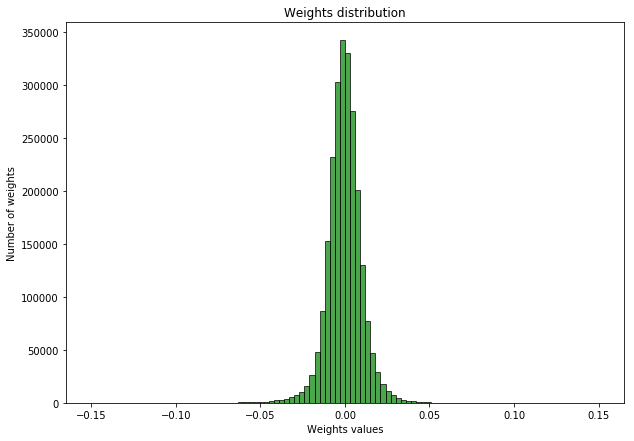

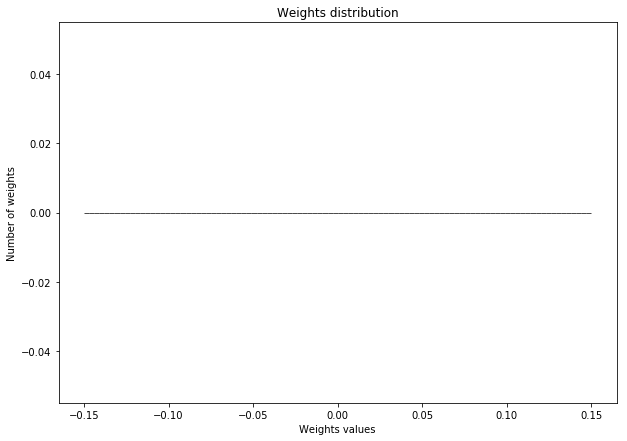

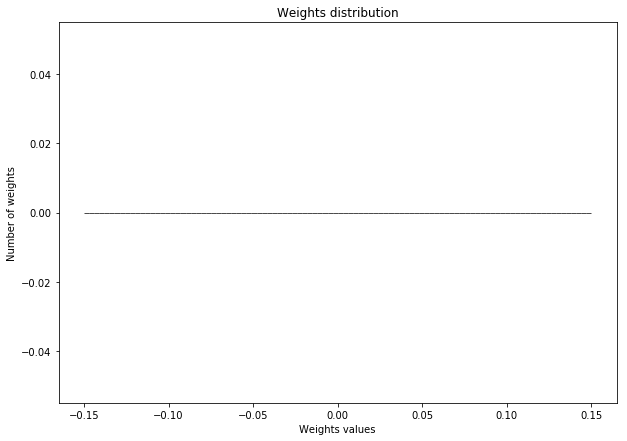

In [77]:
weightPruning(50)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.1029000000655651, loss on test: 2.3187410044670114
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.34it/s]



Epoch 1 completed.
Accuracy on train: 0.10114545444195946, loss on train: 2.306973807161506
Accuracy on validation: 0.09760000053793196, loss on validation: 2.306138916015625
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 122.60it/s]



Epoch 2 completed.
Accuracy on train: 0.10036363623359004, loss on train: 2.3029642395539716
Accuracy on validation: 0.09759999983012675, loss on validation: 2.302217535972595
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.48it/s]



Epoch 3 completed.
Accuracy on train: 0.09852727269923159, loss on train: 2.3020152707533392
Accuracy on validation: 0.09759999979287387, loss on validation: 2.30117434501648
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.56it/s]



Epoch 4 completed.
Accuracy on train: 0.11190909099849816, loss on train: 2.301599661220201
Accuracy on validation: 0.11259999968111517, loss on validation: 2.300964288711548
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 124.18it/s]



Epoch 5 completed.
Accuracy on train: 0.11298181810839628, loss on train: 2.301055056832058
Accuracy on validation: 0.11259999975562093, loss on validation: 2.3008406686782834

Optimization finished.
Accuracy on test: 0.11320000022649765, loss on test: 2.3010564684867867


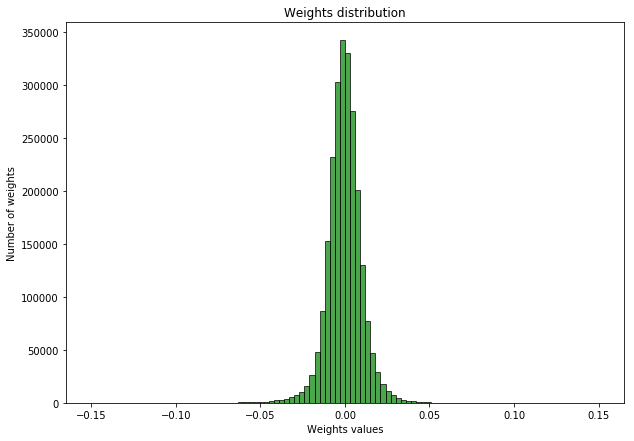

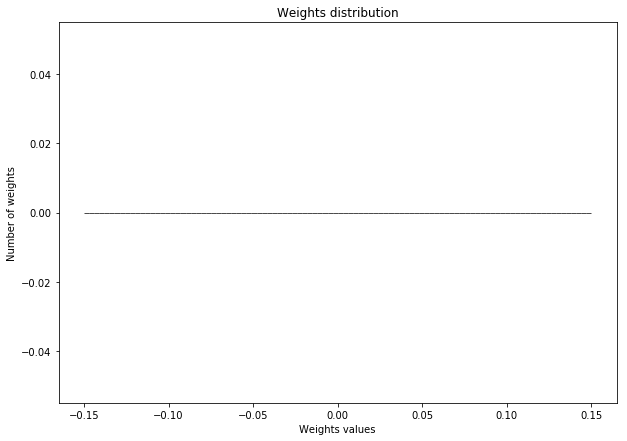

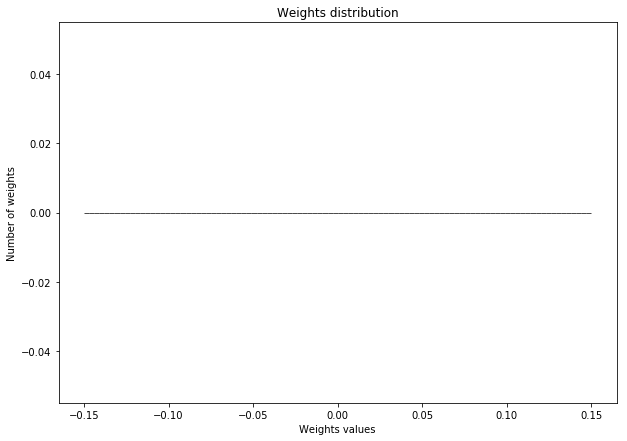

In [78]:
#60, 70, 80, 90, 95, 97, 99
weightPruning(60)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.1033000002428889, loss on test: 2.3185276246070865
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.67it/s]



Epoch 1 completed.
Accuracy on train: 0.10058181796222937, loss on train: 2.307131782011554
Accuracy on validation: 0.09760000057518482, loss on validation: 2.3062360525131225
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.62it/s]



Epoch 2 completed.
Accuracy on train: 0.09865454553541823, loss on train: 2.3034694450551814
Accuracy on validation: 0.0976000001654029, loss on validation: 2.302529692649842
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.76it/s]



Epoch 3 completed.
Accuracy on train: 0.09847272738475718, loss on train: 2.302092574726451
Accuracy on validation: 0.0976000002399087, loss on validation: 2.301285586357117
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 124.01it/s]



Epoch 4 completed.
Accuracy on train: 0.11456363639709646, loss on train: 2.3014774456891143
Accuracy on validation: 0.11259999997913836, loss on validation: 2.3010173797607414
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.87it/s]



Epoch 5 completed.
Accuracy on train: 0.11338181814009511, loss on train: 2.3010770290548126
Accuracy on validation: 0.1126000002026558, loss on validation: 2.3008922243118275

Optimization finished.
Accuracy on test: 0.11339999973773952, loss on test: 2.3011660504341114


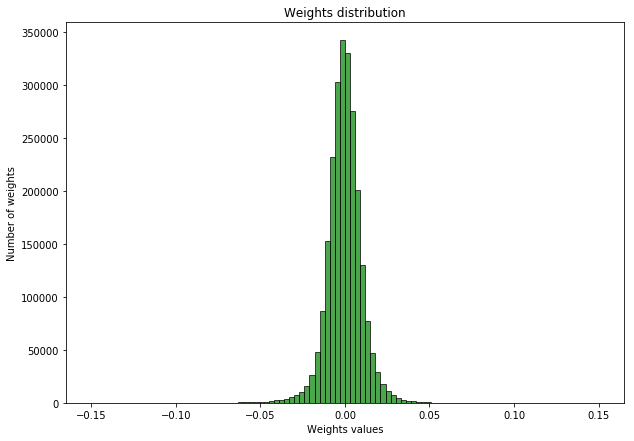

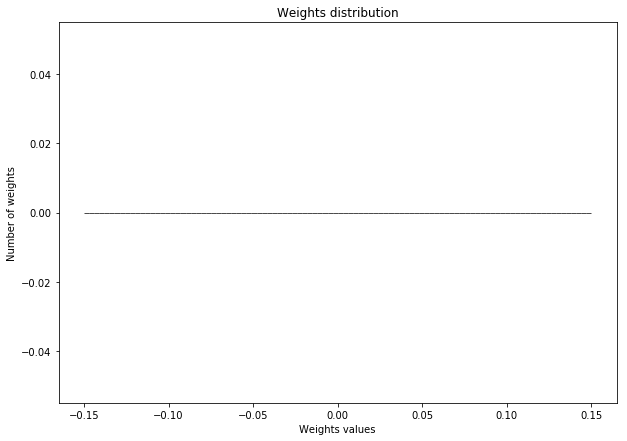

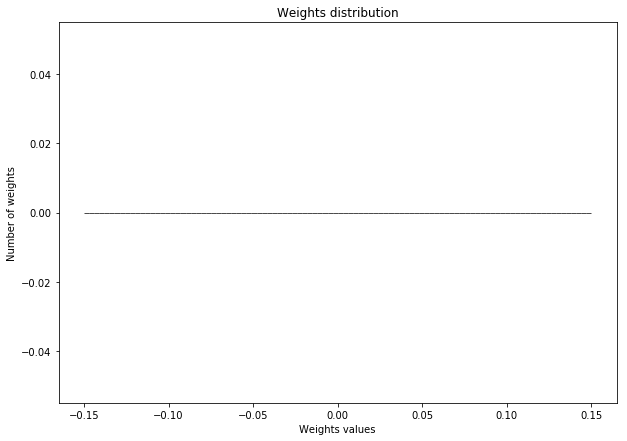

In [79]:
weightPruning(70)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10360000032931567, loss on test: 2.3183759069442758
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.76it/s]



Epoch 1 completed.
Accuracy on train: 0.09856363621286396, loss on train: 2.308188788240605
Accuracy on validation: 0.09759999945759772, loss on validation: 2.306483564376831
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.59it/s]



Epoch 2 completed.
Accuracy on train: 0.10076363636011444, loss on train: 2.3036298595775255
Accuracy on validation: 0.09759999994188544, loss on validation: 2.3024890041351327
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.68it/s]



Epoch 3 completed.
Accuracy on train: 0.1119090907783672, loss on train: 2.3020958636023794
Accuracy on validation: 0.11259999953210352, loss on validation: 2.3011707210540764
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.65it/s]



Epoch 4 completed.
Accuracy on train: 0.11101818205280758, loss on train: 2.301423178152607
Accuracy on validation: 0.11259999975562092, loss on validation: 2.300836138725281
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 124.07it/s]



Epoch 5 completed.
Accuracy on train: 0.11261818165806221, loss on train: 2.3012382563677716
Accuracy on validation: 0.11259999990463254, loss on validation: 2.3008382177352904

Optimization finished.
Accuracy on test: 0.11409999996423718, loss on test: 2.3009668207168574


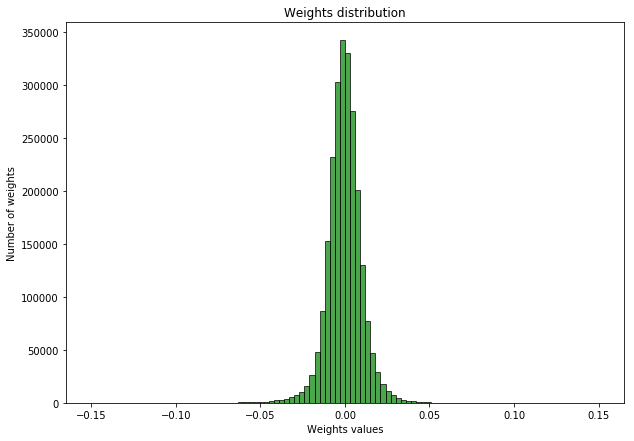

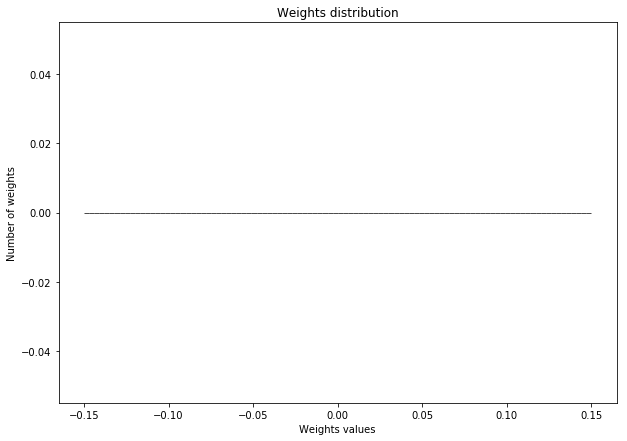

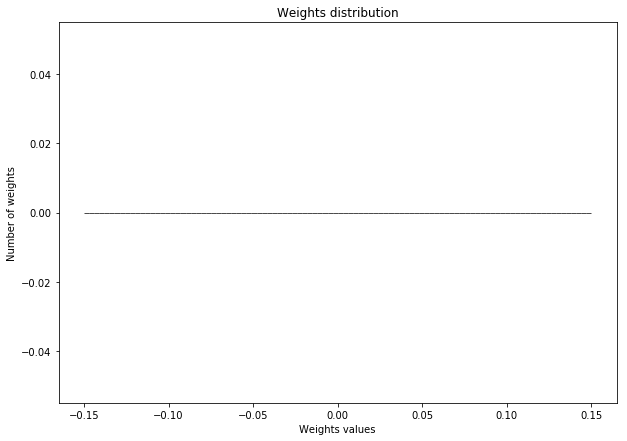

In [80]:
weightPruning(80)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10239999981597066, loss on test: 2.3188883519172676
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 126.30it/s]



Epoch 1 completed.
Accuracy on train: 0.09999999992210776, loss on train: 2.307912505756725
Accuracy on validation: 0.09759999971836807, loss on validation: 2.306452217102051
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.70it/s]



Epoch 2 completed.
Accuracy on train: 0.10043636344711913, loss on train: 2.303314971490342
Accuracy on validation: 0.09760000064969064, loss on validation: 2.302471132278442
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.79it/s]



Epoch 3 completed.
Accuracy on train: 0.09974545451050468, loss on train: 2.3020139542492943
Accuracy on validation: 0.09759999975562098, loss on validation: 2.301237006187439
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 127.76it/s]



Epoch 4 completed.
Accuracy on train: 0.11190909058194302, loss on train: 2.30160201246088
Accuracy on validation: 0.11259999975562095, loss on validation: 2.3008723831176754
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.84it/s]



Epoch 5 completed.
Accuracy on train: 0.11338181803510979, loss on train: 2.3011983520334396
Accuracy on validation: 0.11259999960660932, loss on validation: 2.3007632589340203

Optimization finished.
Accuracy on test: 0.11300000011920926, loss on test: 2.301045680046081


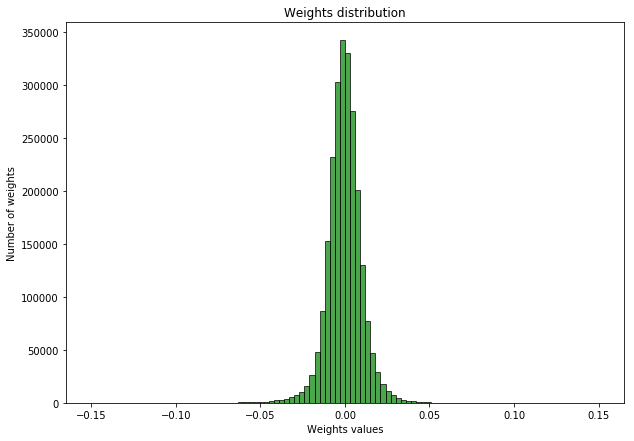

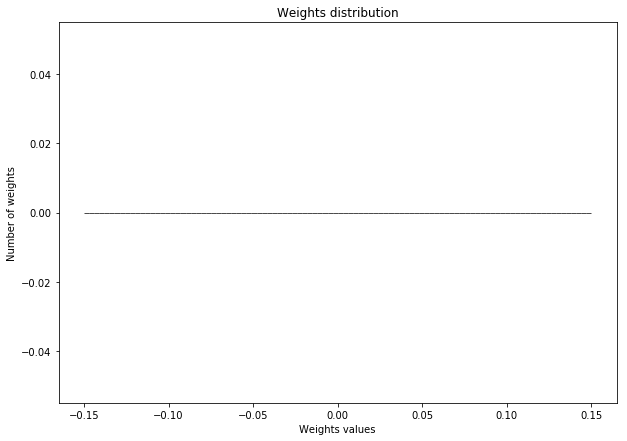

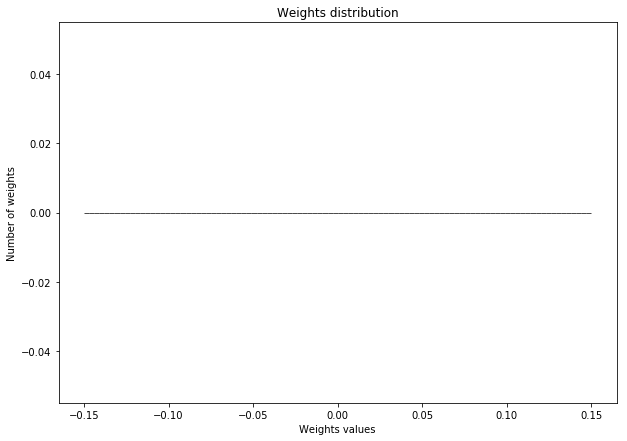

In [81]:
weightPruning(90)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10310000015422703, loss on test: 2.318550798892975
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.51it/s]



Epoch 1 completed.
Accuracy on train: 0.09950909071009297, loss on train: 2.307731161984531
Accuracy on validation: 0.09759999971836805, loss on validation: 2.3065222072601324
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.18it/s]



Epoch 2 completed.
Accuracy on train: 0.10025454538789678, loss on train: 2.303142037391662
Accuracy on validation: 0.09760000064969067, loss on validation: 2.3023920822143555
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 127.27it/s]



Epoch 3 completed.
Accuracy on train: 0.09876363618807378, loss on train: 2.3019373278184387
Accuracy on validation: 0.09759999979287386, loss on validation: 2.301166996955872
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.26it/s]



Epoch 4 completed.
Accuracy on train: 0.11092727287249157, loss on train: 2.3013567517020466
Accuracy on validation: 0.11259999968111517, loss on validation: 2.3008287668228156
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 122.58it/s]



Epoch 5 completed.
Accuracy on train: 0.11389090904119367, loss on train: 2.300960814736105
Accuracy on validation: 0.11259999983012675, loss on validation: 2.300745720863342

Optimization finished.
Accuracy on test: 0.11310000021010634, loss on test: 2.301164679527283


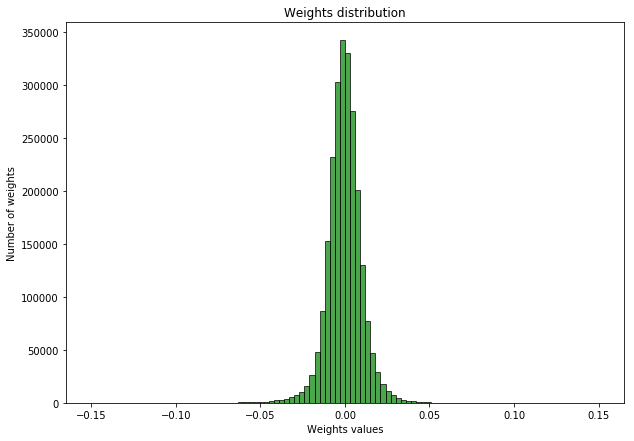

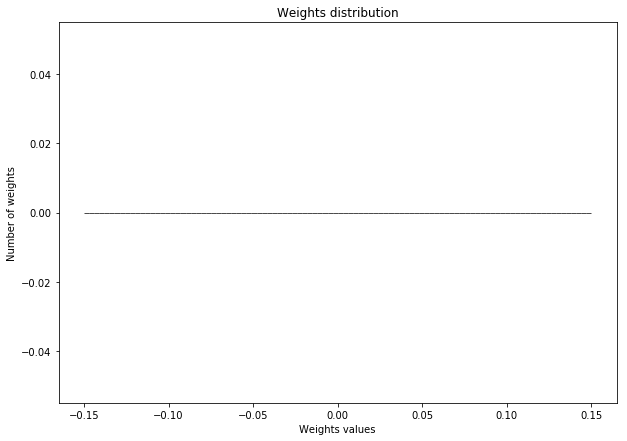

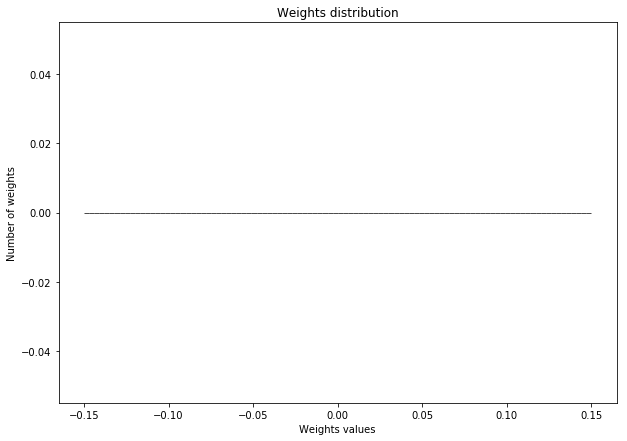

In [82]:
weightPruning(95)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10300000026822094, loss on test: 2.3183724260330205
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.45it/s]



Epoch 1 completed.
Accuracy on train: 0.09789090929383594, loss on train: 2.308834009604021
Accuracy on validation: 0.09759999997913835, loss on validation: 2.3066493558883665
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.68it/s]



Epoch 2 completed.
Accuracy on train: 0.09967272730036231, loss on train: 2.303409560810435
Accuracy on validation: 0.09759999971836805, loss on validation: 2.3026437711715695
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.43it/s]



Epoch 3 completed.
Accuracy on train: 0.09861818189309425, loss on train: 2.3023471650210294
Accuracy on validation: 0.09759999971836804, loss on validation: 2.3014179944992064
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.18it/s]



Epoch 4 completed.
Accuracy on train: 0.11298181809146321, loss on train: 2.3014846459302043
Accuracy on validation: 0.11260000020265579, loss on validation: 2.3009859704971305
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 129.19it/s]



Epoch 5 completed.
Accuracy on train: 0.1130909089303832, loss on train: 2.301362900300461
Accuracy on validation: 0.11260000020265576, loss on validation: 2.3007855606079106

Optimization finished.
Accuracy on test: 0.11339999960735439, loss on test: 2.3010857057571403


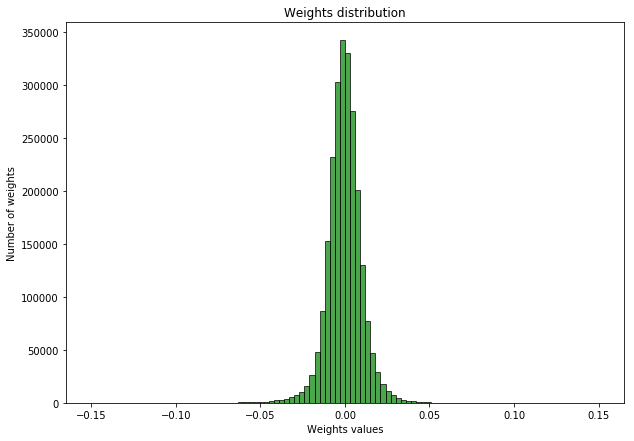

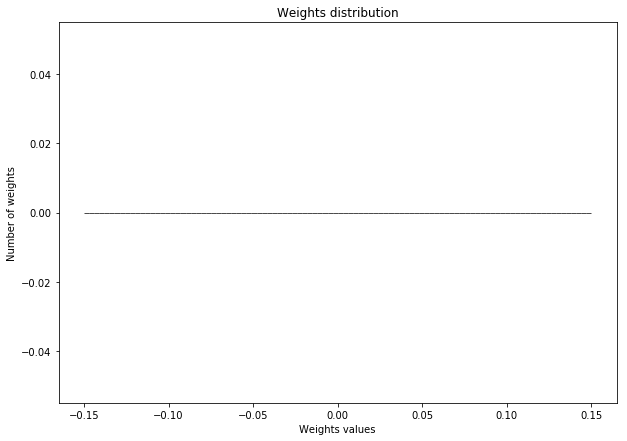

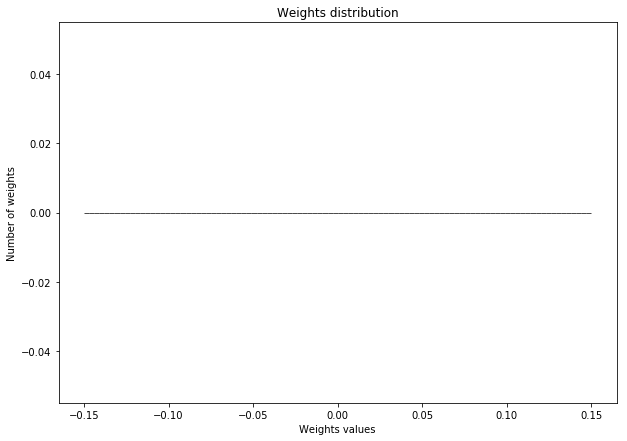

In [83]:
weightPruning(97)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense\model.ckpt-13750
Accuracy on test before fine-tuning: 0.10319999992847448, loss on test: 2.31901231765747
Starting epoch 1.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 110.38it/s]



Epoch 1 completed.
Accuracy on train: 0.09805454555221592, loss on train: 2.308829254670575
Accuracy on validation: 0.09759999994188549, loss on validation: 2.3067320442199715
Starting epoch 2.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.65it/s]



Epoch 2 completed.
Accuracy on train: 0.09761818168515532, loss on train: 2.3038199489766926
Accuracy on validation: 0.09759999968111514, loss on validation: 2.3027407693862916
Starting epoch 3.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.40it/s]



Epoch 3 completed.
Accuracy on train: 0.09907272714782873, loss on train: 2.3022418009151147
Accuracy on validation: 0.09760000005364419, loss on validation: 2.3013114118576055
Starting epoch 4.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 122.96it/s]



Epoch 4 completed.
Accuracy on train: 0.11369090898470477, loss on train: 2.3016525415940703
Accuracy on validation: 0.11259999968111516, loss on validation: 2.3009027242660527
Starting epoch 5.



100%|███████████████████████████████████| 550/550 [00:04<00:00, 123.70it/s]



Epoch 5 completed.
Accuracy on train: 0.11347272693094908, loss on train: 2.30159359628504
Accuracy on validation: 0.1125999999046326, loss on validation: 2.30077832698822

Optimization finished.
Accuracy on test: 0.11319999963045115, loss on test: 2.300955801010131


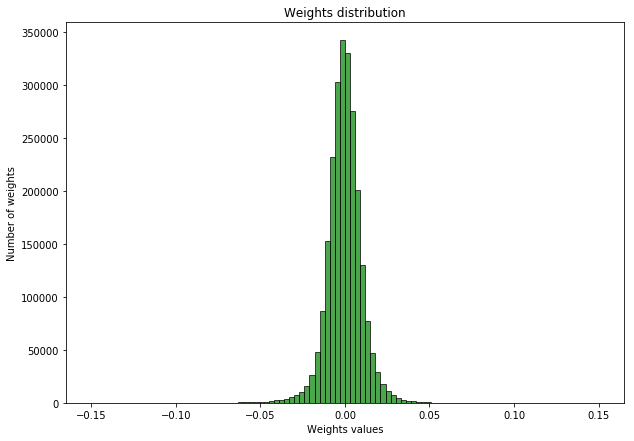

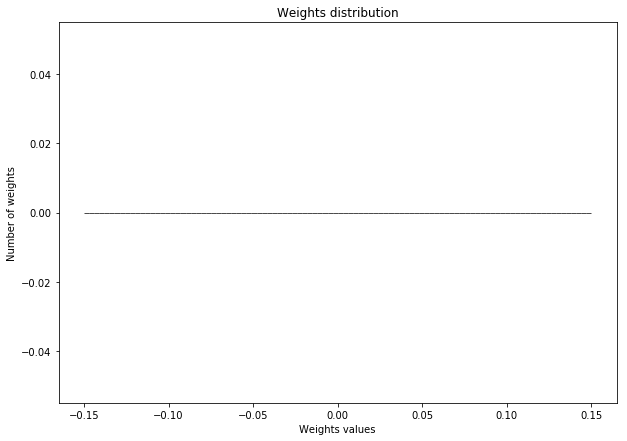

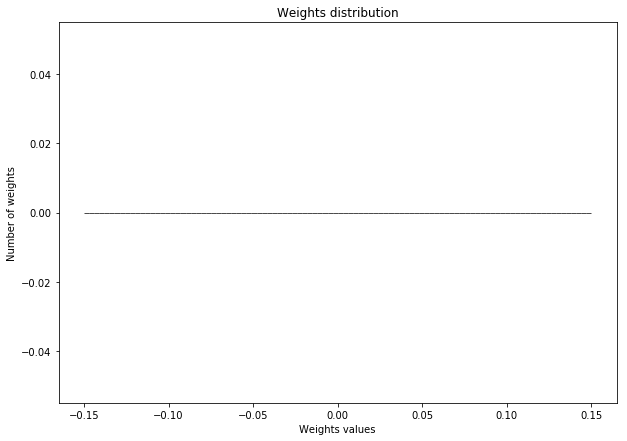

In [84]:
weightPruning(99)

In [20]:
class FullyConnectedClassifierSparse(FullyConnectedClassifier):

    def __init__(self,
                 input_size: int,
                 n_classes: int,
                 sparse_layers: list,
                 model_path: str,
                 activation_fn=tf.nn.relu,
                 scope='FullyConnectedClassifierSparse',
                 verbose=True):

        self.input_size = input_size
        self.n_classes = n_classes
        self.sparse_layers = sparse_layers
        self.model_path = model_path
        self.activation_fn = activation_fn
        self.scope = scope
        self.verbose = verbose

        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.variable_scope(self.scope):

                self._create_placeholders()

                self.logits = self._build_network(inputs=self.inputs,
                                                  sparse_layers=self.sparse_layers,
                                                  activation_fn=self.activation_fn)

                self.loss = self._create_loss(logits=self.logits,
                                              labels=self.labels)

                self._create_metrics(logits=self.logits,
                                     labels=self.labels,
                                     loss=self.loss)

                self.saver = self._create_saver(tf.global_variables())
                self.init_variables(tf.global_variables())

                if self.verbose:
                    print('\nSuccessfully created graph for {model}.'.format(
                                                            model=self.scope))
                    print('Number of parameters (four bytes == 1 parameter): {}.\n'.format(
                         calculate_number_of_sparse_parameters(
                                                            self.sparse_layers)))

    def _create_placeholders(self):
    
        self.inputs = tf.placeholder(dtype=tf.float32,
                                     shape=(None, self.input_size),
                                     name='inputs')
    
        self.labels = tf.placeholder(dtype=tf.int64,
                                     shape=None,
                                     name='labels')

        # for compatibility with dense model
        self.keep_prob = tf.placeholder(dtype=tf.float32,
                                        shape=(),
                                        name='keep_prob')

    def _build_network(self,
                       inputs: tf.Tensor,
                       sparse_layers: list,
                       activation_fn: callable) -> tf.Tensor:
    
        with tf.variable_scope('network'):
    
            net = inputs
    
            self.weight_tensors = []

            bias_initializer = tf.constant_initializer(0.1)

            for i, layer in enumerate(sparse_layers):
    
                with tf.variable_scope('layer_{layer}'.format(layer=i+1)):

                    # create variables based on sparse values                    
                    with tf.variable_scope('sparse'):

                        indicies = tf.get_variable(name='indicies',
                                                   initializer=layer.indices,
                                                   dtype=tf.int16)

                        values = tf.get_variable(name='values',
                                                 initializer=layer.values,
                                                 dtype=tf.float32)

                        dense_shape = tf.get_variable(name='dense_shape',
                                                      initializer=layer.dense_shape,
                                                      dtype=tf.int64)

                    # create a weight tensor based on the created variables
                    weights = tf.sparse_to_dense(tf.cast(indicies, tf.int64),
                                                 dense_shape,
                                                 values)

                    self.weight_tensors.append(weights)
        
                    name = 'bias'
                    bias = tf.get_variable(name=name,
                                           initializer=layer.bias)
    
                    net = tf.matmul(net, weights) + bias
    
                    if i < len(sparse_layers) - 1:
                        net = activation_fn(net)
    
            return net

    def _create_loss(self,
                     logits: tf.Tensor,
                     labels: tf.Tensor) -> tf.Tensor:
    
        with tf.variable_scope('loss'):
            classification_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                                            logits=logits, labels=labels,
                                            name='classification_loss')
    
            classification_loss = tf.reduce_mean(classification_loss,
                                                 name='classification_loss_averaged')

        return classification_loss

# Unit/Neuron Pruning

In [66]:
def get_sparse_values_indices_k(weights,k):
    k_len = len(weights)
    k_len = int(k_len * k)
    weights[0:k_len] = 0
    values = weights[weights != 0]
    indices = np.transpose(np.nonzero(weights))
    return values, indices

In [67]:
def PruningExample(k):
    classifier = FullyConnectedClassifier(
                                input_size=ConfigNetworkDensePruned.input_size,
                                n_classes=ConfigNetworkDensePruned.n_classes,
                                layer_sizes=ConfigNetworkDensePruned.layer_sizes,
                                model_path=ConfigNetworkDensePruned.model_path,
                                dropout=ConfigNetworkDensePruned.dropout,
                                weight_decay=ConfigNetworkDensePruned.weight_decay,
                                activation_fn=ConfigNetworkDensePruned.activation_fn,
                                pruning_threshold=ConfigNetworkDensePruned.pruning_threshold)
    # restore a model
    classifier.load_model()

    accuracy, loss = classifier.evaluate(data_provider=test_data_provider,
                                         batch_size=ConfigNetworkDensePruned.batch_size)
    print('Accuracy on test with dense model (pruned): {accuracy}, loss on test: {loss}'.format(
                                                       accuracy=accuracy, loss=loss))

    weight_matrices, biases = classifier.sess.run([classifier.weight_matrices,
                                                   classifier.biases])
    sparse_layers = []
    # turn dense pruned weights into sparse indices and values
    for weights, bias in zip(weight_matrices, biases):

        if(len(weights[0])!=10):
            values, indices =  get_sparse_values_indices_k(weights,k)
        else:
            values, indices =  get_sparse_values_indices_k(weights,0)
        shape = np.array(weights.shape).astype(np.int64)
        sparse_layers.append( SparseLayer(values=values.astype(np.float32),
                                                       indices=indices.astype(np.int16),
                                                       dense_shape=shape,
                                                       bias=bias))

    # create sparse classifier
    sparse_classifier = FullyConnectedClassifierSparse(
                                input_size=ConfigNetworkSparse.input_size,
                                n_classes=ConfigNetworkSparse.n_classes,
                                sparse_layers=sparse_layers,
                                model_path=ConfigNetworkSparse.model_path,
                                activation_fn=ConfigNetworkSparse.activation_fn)

    # test sparse classifier
    accuracy, loss = sparse_classifier.evaluate(data_provider=test_data_provider,
                                                batch_size=ConfigNetworkSparse.batch_size)
    print('Accuracy on test with sparse model: {accuracy}, loss on test: {loss}'.format(
                                                       accuracy=accuracy, loss=loss))

    # finally, save a sparse model
    sparse_classifier.save_model()
PruningExample(0)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6771999984979632, loss on test: 0.987368630170822

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 73190.

Accuracy on test with sparse model: 0.6777000010013583, loss on test: 0.9738495826721194


# For k@ 25%

In [68]:
PruningExample(0.25)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6768999993801116, loss on test: 0.987739944458008

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 65414.

Accuracy on test with sparse model: 0.3721000003814698, loss on test: 1.6065773761272435


# For @50, 60, 70, 80, 90, 95, 97, 99%

In [56]:
PruningExample(0.60)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6772000026702883, loss on test: 0.987446812391281

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 25692.

Accuracy on test with sparse model: 0.09239999989047648, loss on test: 2.4316023182868958


In [69]:
PruningExample(0.70)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6767000001668932, loss on test: 0.9889129745960237

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 18296.

Accuracy on test with sparse model: 0.11410000018775464, loss on test: 2.9294969868659986


In [58]:
PruningExample(0.80)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6771999984979628, loss on test: 0.9872180175781251

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 9726.

Accuracy on test with sparse model: 0.113999999910593, loss on test: 2.3382524895668033


In [70]:
PruningExample(0.90)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6790000021457673, loss on test: 0.9857576483488083

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 8126.

Accuracy on test with sparse model: 0.11409999951720236, loss on test: 2.568957347869873


In [71]:
PruningExample(0.95)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6786000019311904, loss on test: 0.9839457023143765

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 7060.

Accuracy on test with sparse model: 0.11399999979883428, loss on test: 2.563021259307861


In [72]:
PruningExample(0.97)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.677400000691414, loss on test: 0.9863543599843979

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 6726.

Accuracy on test with sparse model: 0.10379999935626981, loss on test: 2.5189398050308225


In [73]:
PruningExample(0.99)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-24750
Accuracy on test with dense model (pruned): 0.6793000024557115, loss on test: 0.9850154411792755

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 6260.

Accuracy on test with sparse model: 0.10289999986067415, loss on test: 2.50021512746811


In [85]:
PruningExample(0.50)


Successfully created graph for FullyConnectedClassifier.
Number of parameters (four bytes == 1 parameter): 2388711.

INFO:tensorflow:Restoring parameters from saved_models/network_dense_pruned\model.ckpt-16500
Accuracy on test with dense model (pruned): 0.11350000020116568, loss on test: 2.301169667243957

Successfully created graph for FullyConnectedClassifierSparse.
Number of parameters (four bytes == 1 parameter): 2730.

Accuracy on test with sparse model: 0.1139999995566904, loss on test: 2.3009239006042477
